In [ ]:
import pyVHR as vhr
import numpy as np
import matplotlib.pyplot as plt

# Plotting: set 'colab' for Google Colaboratory, 'notebook' otherwise
vhr.plot.VisualizeParams.renderer = 'notebook'  # or 'notebook'

In [ ]:
# -- LOAD A DATASET
dataset_name = 'lgi_ppgi'          # the name of the python class handling it 
video_DIR = '../cpi/id3/cpi_resting/'  # dir containing videos
BVP_DIR = '../cpi/id3/cpi_resting/'    # dir containing BVPs GT

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)

dataset.video_EXT = 'mp4'
dataset.__init__(videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

In [ ]:
# -- PARAMETER SETTING
wsize = 8          # seconds of video processed (with overlapping) for each estimate 
video_idx = 0      # index of the video to be processed
fname = dataset.getSigFilename(video_idx)
sigGT = dataset.readSigfile(fname)
test_bvp = sigGT.data
bpmGT, timesGT = sigGT.getBPM(wsize)
videoFileName = dataset.getVideoFilename(video_idx)
print('Video processed name: ', videoFileName)
fps = vhr.extraction.utils.get_fps(videoFileName)
print('Video frame rate:     ',fps)

In [ ]:
sig_extractor = vhr.extraction.SignalProcessing()
# sig_extractor.display_cuda_device()
# sig_extractor.choose_cuda_device(0)

Use convex hull or face parsing to extract the skin

In [ ]:
# CPU based
sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull())
#sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionFaceParsing('CPU'))

# GPU based
# sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionConvexHull('GPU'))
#sig_extractor.set_skin_extractor(vhr.extraction.SkinExtractionFaceParsing('GPU'))

Choose a specific number of frames of the video to process... 

In [ ]:
# set the number of seconds (0 for all video)
seconds = 20
sig_extractor.set_total_frames(seconds*fps)

### Color-thresholding

**OPTIONAL**: Both signal extraction and skin extraction have a color-threshold filter for removing unwanted RGB colors. We can set the RGB threshold interval using theese classes:

In [ ]:
vhr.extraction.SkinProcessingParams.RGB_LOW_TH = 2
vhr.extraction.SkinProcessingParams.RGB_HIGH_TH = 254

vhr.extraction.SignalProcessingParams.RGB_LOW_TH = 2
vhr.extraction.SignalProcessingParams.RGB_HIGH_TH = 254

In [ ]:
# -- SET VISUALIZATION MODE 
sig_extractor.set_visualize_skin_and_landmarks(
      visualize_skin=True, 
      visualize_landmarks=True, 
      visualize_landmarks_number=True, 
      visualize_patch=True)

In [ ]:
# -- DEFINE A LANDMARK SUBSET

# choose predefined...
landmarks = vhr.extraction.MagicLandmarks.cheek_left_top +\
                   vhr.extraction.MagicLandmarks.forehead_center +\
                   vhr.extraction.MagicLandmarks.forehoead_right +\
                   vhr.extraction.MagicLandmarks.cheek_right_top +\
                   vhr.extraction.MagicLandmarks.forehead_left +\
                   vhr.extraction.MagicLandmarks.nose 


In [ ]:
# -- SET THE LANDMARK LIST
sig_extractor.set_landmarks(landmarks)

## Holistic extraction

In [ ]:
# -- HOLISTIC EXTRACTION
hol_sig = sig_extractor.extract_holistic(videoFileName)
print('Size: (#frames, #landmarks, #channels) = ',hol_sig.shape)

In [ ]:
# -- INTERACTIVE VISUALIZATION OF PATCHES
visualize_skin_coll = sig_extractor.get_visualize_skin()
print('Number of frames processed: ',len(visualize_skin_coll))
vhr.plot.interactive_image_plot(visualize_skin_coll,1.0)

In [ ]:
f_mask = np.array(visualize_skin_coll[0]!=0,dtype=np.bool)
b_mask = np.array(visualize_skin_coll[0]==0,dtype=np.bool)

In [255]:
image = visualize_skin_coll[0]
(row,col,ch) = image.shape
noisy=np.copy(image)
for ch in range(image.shape[2]):
    mean = 0
    sigma = 40
    gauss = np.random.normal(mean,sigma,(row,col)).astype(np.uint8)
    noisy[:,:,ch] = noisy[:,:,ch] + gauss # potentielt problem her for hvis værdierne kommer over 255, wrapper de rundt.
noisy[b_mask]=0


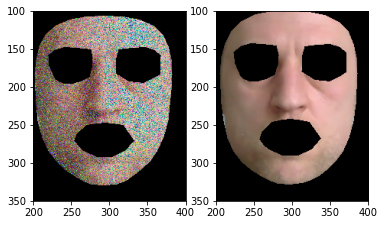

In [256]:
fig,ax=plt.subplots(1,2,figsize=(6,5))
for i in range(2):
    ax[i].set_xlim(200,400)
    ax[i].set_ylim(350,100)
    ax[0].imshow(noisy)
    ax[1].imshow(visualize_skin_coll[1])

In [ ]:
import cv2

In [ ]:
cap = cv2.VideoCapture(video_DIR+"cv_camera_sensor_stream_handler.mp4")
frameRate = cap.get(5)  # frame rate

# Frame dimensions: WxH
frame_dims = (int(cap.get(3)), int(cap.get(4)))
num_frames = int(cap.get(7))

# the following just reads all the frames into a numpy array
# Frames from the video have shape NumFrames x H x W x C
max_frames = seconds * fps
if max_frames < num_frames:
    num_frames = int(max_frames)
frames = np.zeros((num_frames, frame_dims[1], frame_dims[0], 3), dtype='uint8')

frame_counter = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frames[frame_counter, :, :, :] = frame
    frame_counter += 1
    if frame_counter == num_frames:
        break

cap.release()

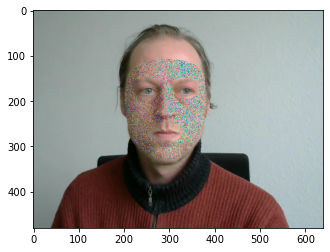

In [257]:
mask = (f_mask.astype(np.int)*255)[:,:,0]
mask = mask.astype(np.uint8)
fg = cv2.bitwise_or(noisy, noisy, mask=mask)

mask = (b_mask.astype(np.int)*255)[:,:,0]
mask = mask.astype(np.uint8)
bg = cv2.bitwise_or(frames[0,:,:,:], frames[0,:,:,:], mask=mask)
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
im = fg + bg
plt.imshow(im)

https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
https://automaticaddison.com/how-to-apply-a-mask-to-an-image-using-opencv/

In [268]:
video = cv2.VideoWriter('mod.mp4',0,25,(frame_dims[0], frame_dims[1]))

In [270]:
for i in range(num_frames):
    image = visualize_skin_coll[i]
    noisy=np.copy(image)
    (row,col,ch) = image.shape
    for ch in range(image.shape[2]):
        mean = 0
        sigma = 40
        gauss = np.random.normal(mean,sigma,(row,col)).astype(np.uint8)
        noisy[:,:,ch] = noisy[:,:,ch] + gauss # potentielt problem her for hvis værdierne kommer over 255, wrapper de rundt.
    noisy[b_mask]=0
    f_mask = np.array(visualize_skin_coll[0]!=0,dtype=np.bool)
    b_mask = np.array(visualize_skin_coll[0]==0,dtype=np.bool)
    mask = (f_mask.astype(np.int)*255)[:,:,0]
    mask = mask.astype(np.uint8)
    fg = cv2.bitwise_or(noisy, noisy, mask=mask)

    mask = (b_mask.astype(np.int)*255)[:,:,0]
    mask = mask.astype(np.uint8)
    bg = cv2.bitwise_or(frames[i,:,:,:], frames[0,:,:,:], mask=mask)
    bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
    im = fg + bg
    video.write(im)
video.release()